In [4]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
from tools.model import Unet

In [5]:
model = Unet().to('cuda')

In [6]:
checkpoint = torch.load('/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_notebooks/cnn/model_piunet_opt_b3_elr/model_10001.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [7]:
from tools.load import create_pair, nc_list

In [8]:
file_list = nc_list("/mnt/obsdata/isee_nlfff_v1.2/12673")
len(file_list)

389

In [9]:
file_list[239]

PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170906_083600.nc')

In [10]:
b_norm = 2500

In [11]:
# inputs, outputs = create_pair(file_list[239], b_norm=b_norm)
# np.save('data/inputs_12673.npy', inputs)
# np.save('data/outputs_12673.npy', outputs)
inputs = np.load('data/inputs_12673.npy')
outputs = np.load('data/outputs_12673.npy')

In [12]:
inputs = torch.Tensor(inputs).to('cuda')
labels = outputs

inputs.shape, labels.shape

(torch.Size([3, 513, 257, 1]), (3, 513, 257, 50))

In [13]:
model_input = torch.permute(inputs, (3, 2, 1, 0))[None, ...]
model_input.shape

torch.Size([1, 1, 257, 513, 3])

In [14]:
b = model(model_input)
b = b.cpu().detach().numpy().transpose(0, 3, 2, 1, 4)*b_norm

In [15]:
b.shape

(1, 513, 257, 50, 3)

In [16]:
B = labels*b_norm
B = B[None, ...].transpose(0, 2, 3, 4, 1)
B.shape

(1, 513, 257, 50, 3)

In [17]:
b = b[0, ...]
B = B[0, ...]

b.shape, B.shape

((513, 257, 50, 3), (513, 257, 50, 3))

In [18]:
from tools.ploting import plot_overview
from tools.metric import evaluate
from tools.metric_another import metrics

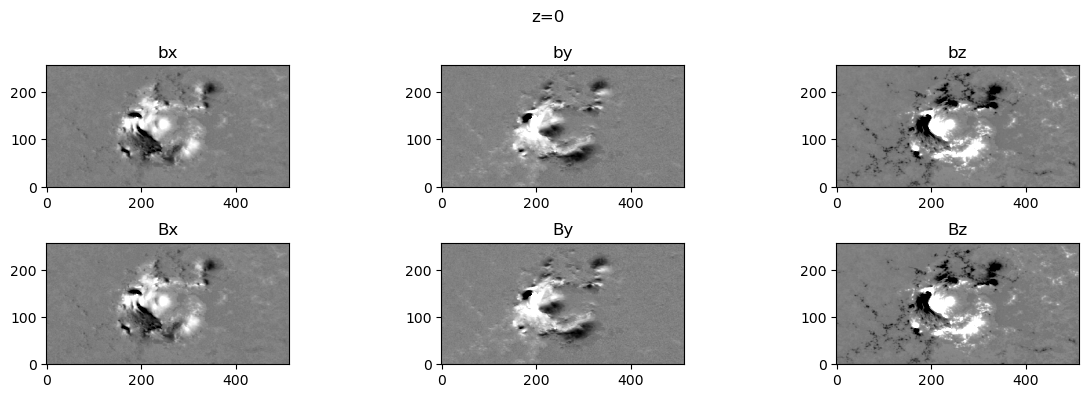

In [19]:
plot_overview(b, B, z=0, b_norm=1000)

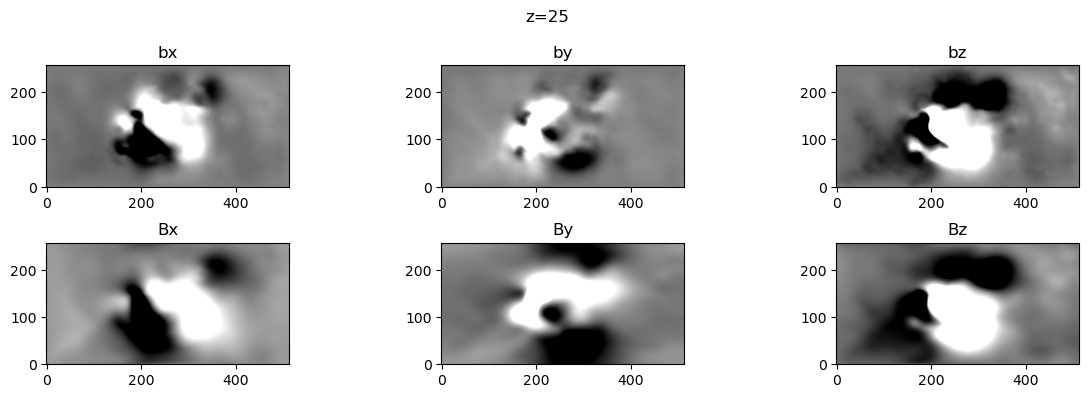

In [20]:
plot_overview(b, B, z=25, b_norm=100)

In [21]:
evaluate(b, B)

/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:58: RuntimeWarning: invalid value encountered in divide
  result['C_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:63: RuntimeWarning: divide by zero encountered in divide
  E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:76: RuntimeWarning: invalid value encountered in divide
  result['sig_J_1e2_B'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:81: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'C_vec': 0.9394243358301141,
 'C_cs': nan,
 "E_n'": 0.5128113923411384,
 "E_m'": -inf,
 'eps': 0.9408365196974704,
 'sig_J_1e2': 66.17883620305368,
 'sig_J_1e2_B': nan,
 'L1': 284.3728,
 'L2': 144.4196,
 'L1_B': nan,
 'L2_B': 175.9493615073281,
 'L2n': 10.451187193393707,
 'L2n_B': 2414762027.1988177}

In [22]:
metrics(b, B)

{'c_vec': 0.9394243358301141,
 'c_cs': 0.5170159521716585,
 'c_cs_ep': 0.5170159521344619,
 "E_n'": 0.5128113923411384,
 "E_m'": 0.20219074725977093,
 "E_m'_ep": -386106.5643051838,
 'eps': 0.9408365196974704}

In [23]:
import matplotlib.pyplot as plt

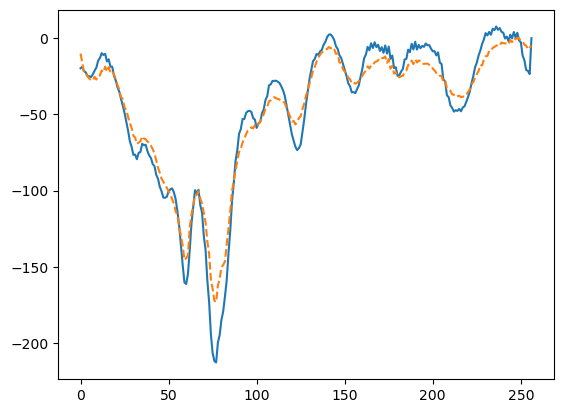

In [24]:
plt.plot(B[..., 5, 2][100, :])
plt.plot(b[..., 5, 2][100, :], '--')